In [13]:
import pymc3 as pm
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = load_diabetes()

X_tr, X_te, y_tr, y_te = train_test_split(data['data'], data['target'])

In [7]:
class BayesRegression:
    
    def __init__(self, burn=1000):
        self.linear_model = pm.Model()
        self.burn = burn
    
    def fit(self, X, y, sample_size=5000, alpha_uncertainty = 10, 
            beta_uncertainty = 1000, sigma_uncertainty=100, cores=None):
        
        with self.linear_model: 
            # ======================= Priors =======================
            alpha = pm.Normal("alpha", mu=y.mean(),sd=alpha_uncertainty)
            betas = pm.Normal("betas", mu=0, sd=beta_uncertainty, shape=X.shape[1])
            # TODO Check out HalfCauchy -- longer/fatter tails
            sigma = pm.HalfNormal("sigma", sd=sigma_uncertainty)
            # ======================================================
            mu = alpha + pm.math.dot(betas, X.T)
            likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed=y)
            step = pm.NUTS()
            trace = pm.sample(sample_size, step, cores=cores)
        
        self.chain = trace[self.burn:]
        self.alpha = self.chain.alpha
        self.betas = self.chain.betas
        self.sigma = self.chain.sigma
        
        
    def predict(self, X):
        
        return self.alpha.mean() + np.dot(X, self.betas.mean(axis=0))
    
    
    def traceplot(self):
        pm.traceplot(self.chain)

Sequential sampling (2 chains in 1 job)
NUTS: [sigma, betas, alpha]
100%|██████████| 1500/1500 [00:05<00:00, 271.54it/s]


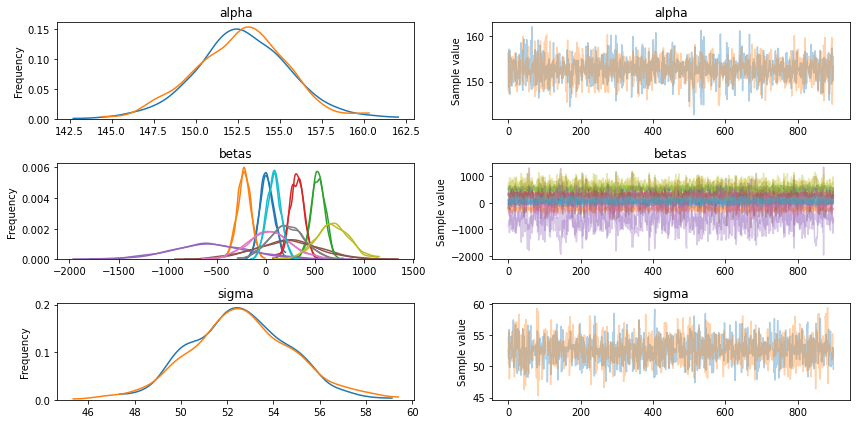

In [8]:
bayes = BayesRegression(burn=100)
bayes.fit(X_tr, y_tr, sample_size=1000, cores=1)

bayes.traceplot();

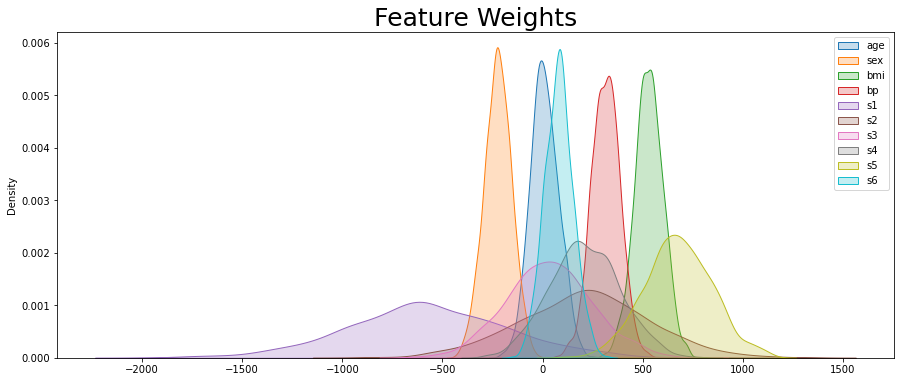

In [57]:
plt.figure(figsize=(15,6))
for idx in range(10):
    sns.kdeplot(bayes.betas[:,idx], shade=True, label=data['feature_names'][idx])
    percentile = np.percentile(bayes.betas[:,idx], 95)
plt.legend()
plt.title('Feature Weights', size=25);

In [47]:
list(zip(data['feature_names'], np.mean(bayes.betas, axis=0)))

[('age', 8.819964471040334),
 ('sex', -224.48467347364013),
 ('bmi', 529.9699509824092),
 ('bp', 313.7560282510246),
 ('s1', -577.1869270526857),
 ('s2', 208.61322822085145),
 ('s3', 31.764168312514865),
 ('s4', 209.89998659533208),
 ('s5', 676.6243448781753),
 ('s6', 80.0832965438331)]

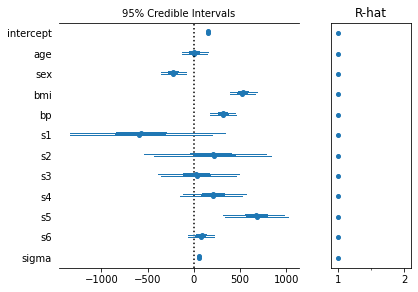

In [69]:
pm.forestplot(bayes.chain, ylabels = ['intercept'] + list(data['feature_names']) + ['sigma']);

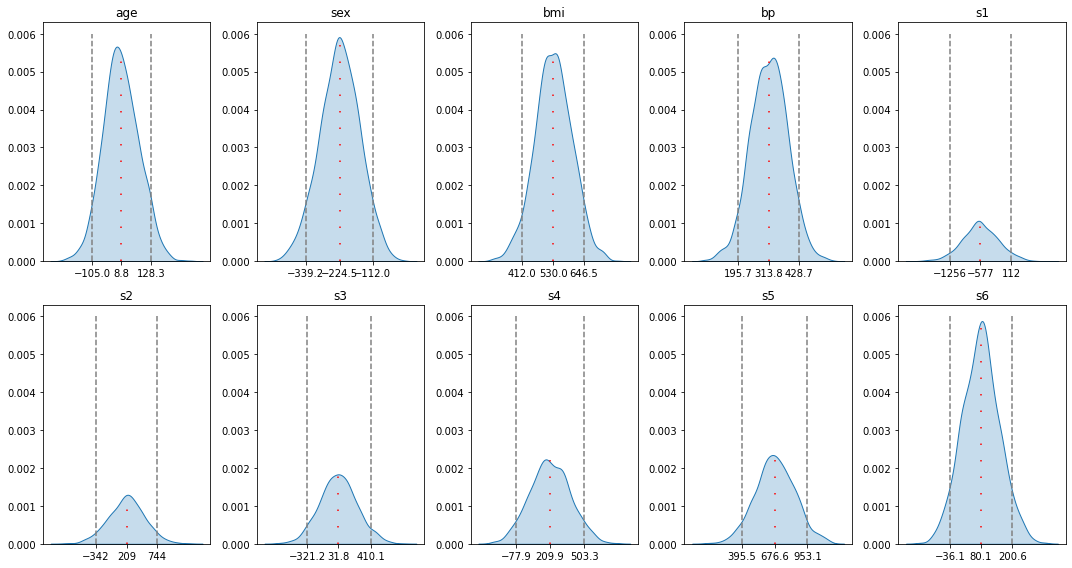

In [115]:
fig, axes = plt.subplots(2,5, figsize=(15,8))

for idx in range(10):
    row, col = idx//5, idx%5
    ax = axes[row, col]
    ax.set_title(data['feature_names'][idx])
    bounds = sns.kdeplot(bayes.betas[:,idx], shade=True, ax=ax)
    upper_percentile = np.percentile(bayes.betas[:,idx], 95)
    lower_percentile = np.percentile(bayes.betas[:,idx], 5)
    ax.vlines(bayes.betas[:,idx].mean(),0 , bounds.dataLim.bounds[-1], color='red', linestyle=(0, (1, 10)), label='Mean')
    ax.vlines(upper_percentile, 0, 0.006, linestyle='--', color='grey', label='95% Confidence')
    ax.vlines(lower_percentile, 0, 0.006, linestyle='--', color='grey')
    ax.set_ylabel('')
    ax.set_xticks([lower_percentile, bayes.betas[:,idx].mean(), upper_percentile])

fig.tight_layout()

In [70]:
sklearn = LinearRegression()

sklearn.fit(X_tr, y_tr)

LinearRegression()

Bayes Train Error:   2656.078218272428
Sklearn Train Error: 2653.8209388584464
Bayes Test Error:   3522.0922162536085
Sklearn Test Error: 3522.451242512199




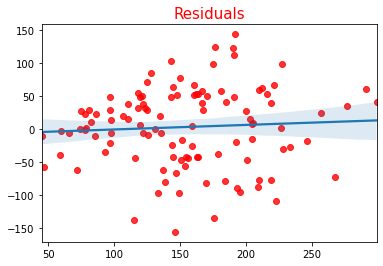

In [143]:
bayes_preds = bayes.predict(X_tr)
sklearn_preds = sklearn.predict(X_tr)


bayes_e = mean_squared_error(y_tr, bayes_preds)
sk_e = mean_squared_error(y_tr, sklearn_preds)

print('==============================================')
print('Bayes Train Error:  ', bayes_e)
print('Sklearn Train Error:', sk_e)
print('==============================================')

bayes_preds = bayes.predict(X_te)
sklearn_preds = sklearn.predict(X_te)

bayes_e = mean_squared_error(y_te, bayes_preds)
sk_e = mean_squared_error(y_te, sklearn_preds)

print('Bayes Test Error:  ', bayes_e)
print('Sklearn Test Error:', sk_e)
print('==============================================')
print()
print()

sns.regplot(x=bayes_preds, y=bayes_preds - y_te, scatter_kws={'color':'red'})
plt.title('Residuals', fontsize=15, color='red');